In [1]:
## import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import plotly.express as px
from plottable import ColumnDefinition, Table

import seaborn as sns
import numpy as np

import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split

# Multiple Linear Regression
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,
 summarize,
 poly)
from statsmodels.stats.outliers_influence \
 import variance_inflation_factor as VIF

import random
random.seed(34)

In [2]:
data = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv", index_col="Person ID")
# data.info()

# 1. Introduction

Data to the project have been downloaded from the kaggle website: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset. The objective is to predict *Quality of Sleep*. It is beneficial to be able to identify the factors that contribute to a good night's sleep, as this enables us to take appropriate measures to ensure we get the requisite amount of rest. \
The study will employ a variety of well-established machine learning techniques, including . Additionally, statistical methods will be utilized: 

# 2. Dataset

| Column                             | Data Type      | Description                                                                 |
|------------------------------------|----------------|-----------------------------------------------------------------------------|
| Gender                             | Object         | The gender of the person (Male/Female).                                    |
| Age                                | Int64          | The age of the person in years.                                            |
| Occupation                         | Object         | The occupation or profession of the person.                                |
| Sleep Duration (hours)             | Float64        | The number of hours the person sleeps per day.                             |
| Quality of Sleep (scale: 1-10)     | Int64          | A subjective rating of the quality of sleep, ranging from 1 to 10.         |
| Physical Activity Level (minutes/day) | Int64       | The number of minutes the person engages in physical activity daily.       |
| Stress Level (scale: 1-10)         | Int64          | A subjective rating of the stress level experienced by the person, from 1 to 10. |
| BMI Category                       | Object         | The BMI category of the person (e.g., Underweight, Normal, Overweight).    |
| Blood Pressure (systolic/diastolic)| Object         | The blood pressure measurement, indicated as systolic over diastolic pressure. |
| Heart Rate (bpm)                   | Int64          | The resting heart rate of the person in beats per minute.                  |
| Daily Steps                        | Int64          | The number of steps the person takes per day.                              |
| Sleep Disorder                     | Object         | The presence or absence of a sleep disorder (None, Insomnia, Sleep Apnea). |

\
The dateset contains 12 columns and 374 columns. The initial five rows are printed below. It can be observed that the column designated *Sleep Disorder* contains NaN values. However, upon printing the unique values for this column, it can be concluded that the individual in question does not suffer from a sleep disorder. The remaining columns do not exhibit any instances of missing data. The second issue is the presentation of the blood pressure data, which is currently presented in a single column and has the data type object. It would be more appropriate to split this data into two columns, one for systolic and one for diastolic blood pressure, with the data types integer for both.


In [3]:
data.sample(7)
# data['Sleep Disorder'].unique()
# data['BMI Category'].unique()
data.describe()

Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
count  374.000000      374.000000        374.000000               374.000000   
mean    42.184492        7.132086          7.312834                59.171123   
std      8.673133        0.795657          1.196956                20.830804   
min     27.000000        5.800000          4.000000                30.000000   
25%     35.250000        6.400000          6.000000                45.000000   
50%     43.000000        7.200000          7.000000                60.000000   
75%     50.000000        7.800000          8.000000                75.000000   
max     59.000000        8.500000          9.000000                90.000000   

       Stress Level  Heart Rate   Daily Steps  
count    374.000000  374.000000    374.000000  
mean       5.385027   70.165775   6816.844920  
std        1.774526    4.135676   1617.915679  
min        3.000000   65.000000   3000.000000  
25%        4.000000   68.000000   5600.000000  
50%        5.000000   70.000000   7000.000000  
75%        7.000000   72.000000   8000.000000  
max        8.000000   86.000000  10000.000000

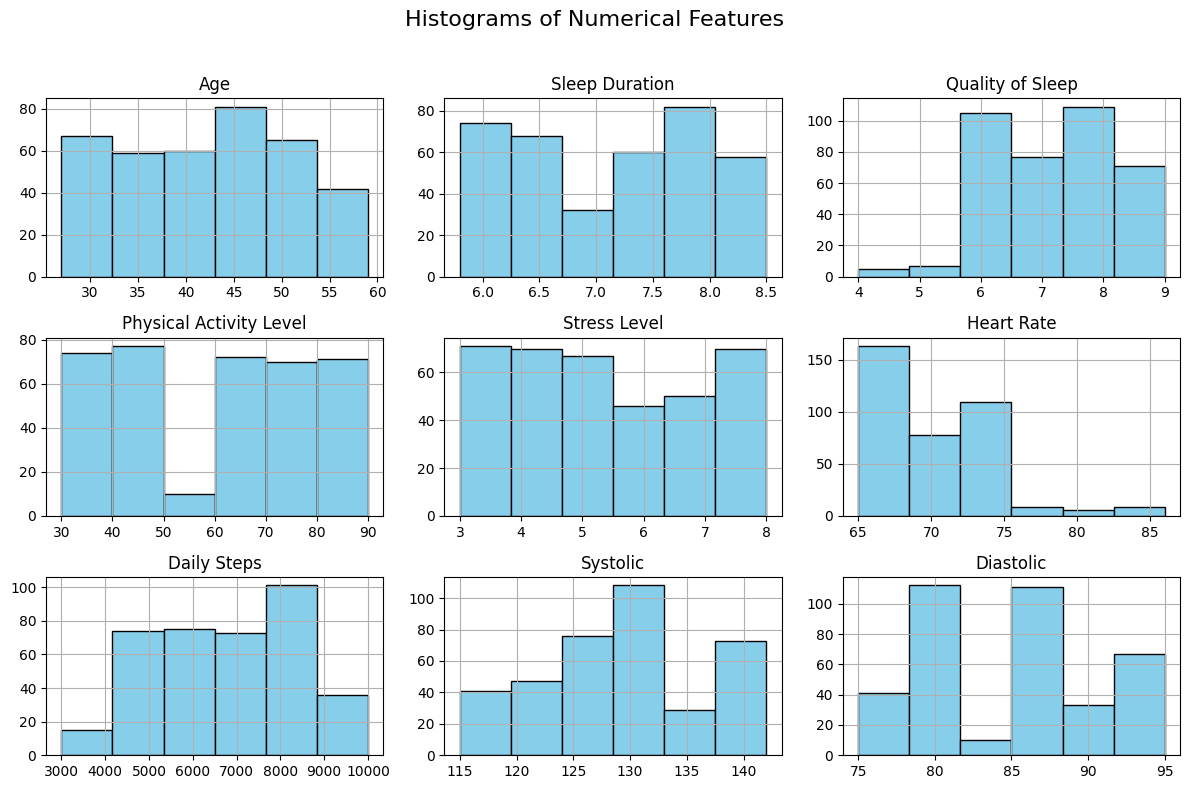

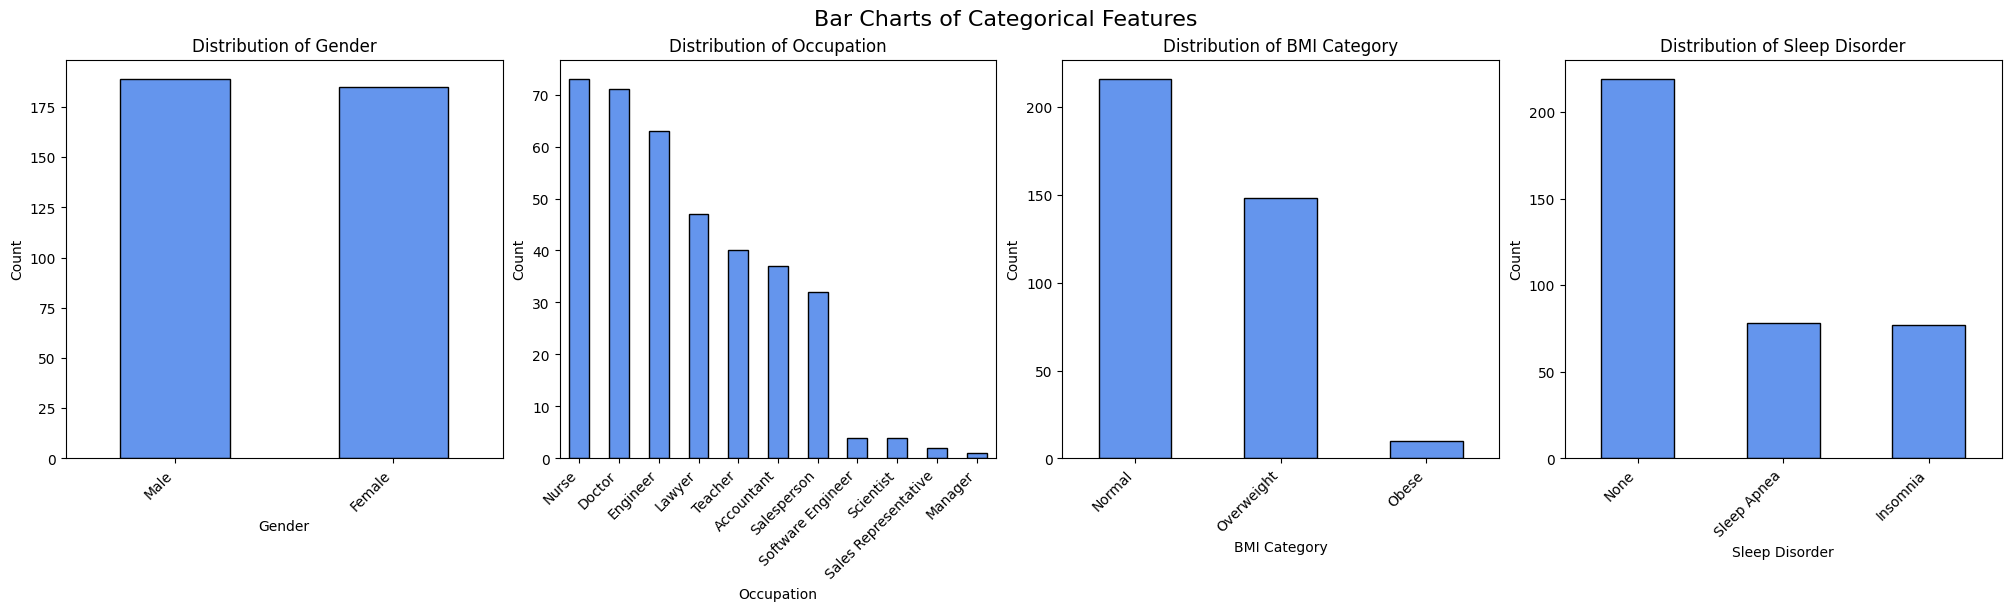

In [4]:
data[['Systolic', 'Diastolic']] = data['Blood Pressure'].str.split('/', expand=True)
data['Systolic'] = data['Systolic'].astype(int)
data['Diastolic'] = data['Diastolic'].astype(int)
data['BMI Category'] = data['BMI Category'].replace('Normal Weight', 'Normal')
data['Sleep Disorder'] = data['Sleep Disorder'].fillna('None')

# histograms for numerical features
data.hist(bins=6, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# bar charts for categorical features
categorical_features = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']

# figure for bar plots
fig, axes = plt.subplots(1, len(categorical_features), figsize=(20, 6), constrained_layout=True)

# Loop through categorical features and create bar plots
for i, categorical_feature in enumerate(categorical_features):
    ax = axes[i] if len(categorical_features) > 1 else axes  # Handle single plot case
    counts = data[categorical_feature].value_counts()
    counts.plot(kind='bar', ax=ax, color='cornflowerblue', edgecolor='black')
    ax.set_title(f'Distribution of {categorical_feature}', fontsize=12)
    ax.set_xlabel(categorical_feature, fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_xticklabels(counts.index, rotation=45, ha='right')

# Add a common title for bar plots
plt.suptitle('Bar Charts of Categorical Features', fontsize=16)
plt.show()


The data set includes working individuals across a range of age groups, with a minimum age of 27 and a maximum age of 59. The majority of the subjects reported having good quality sleep. The prevalence of individuals reporting a quality of sleep equal to or greater than 6 is 75%. Furthermore, 25% of the respondents indicated a quality of sleep equal to or greater than 8. In contrast, the distribution of values in the 'Stress level' category is more uniform, with a median score of 5. High level of stress is understandable, because most of responders are nurse and doctors, who have a high level of responsibility in their roles. The majority of the current population leads a healthy lifestyle, with the vast majority engaging in at least 30 minutes of physical activity on a daily basis and half of them exceeding the recommended 7,000 steps per day. Furthermore, the data concerning heart rate and blood pressure are also representative of a positive outcome. Nevertheless, nearly half of the respondents reported some form of sleep disorder. \
Prior to the construction of a model, an investigation into the correlation matrix will also be conducted.

In [5]:
data.columns

Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category',
       'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder',
       'Systolic', 'Diastolic'],
      dtype='object')

C:\Users\diana\AppData\Local\Temp\ipykernel_12644\2331588757.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_BMICategory = data['BMI Category'].replace(['Normal', 'Overweight', 'Obese'], [0, 1, 2])


<Axes: >

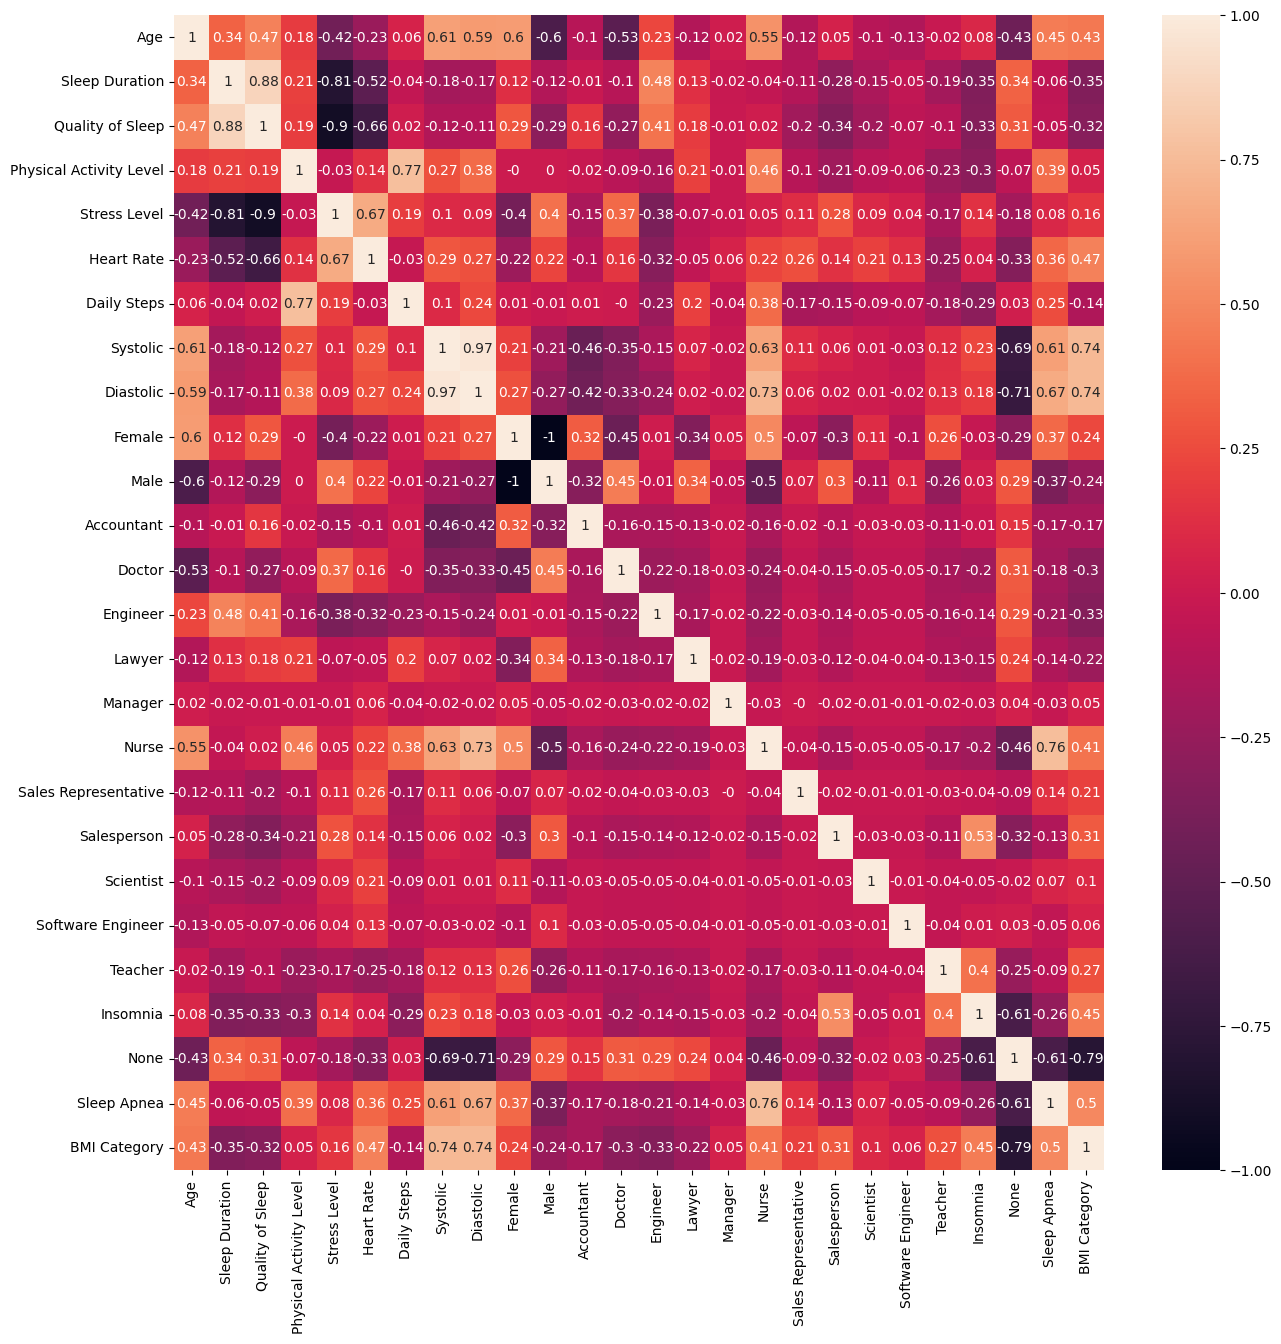

In [6]:
dummies_gender = pd.get_dummies(data['Gender'])
dummies_Occupation = pd.get_dummies(data['Occupation'])
dummies_SpleepDisorder = pd.get_dummies(data['Sleep Disorder'])
numeric_BMICategory = data['BMI Category'].replace(['Normal', 'Overweight', 'Obese'], [0, 1, 2])
data_with_dummies = pd.concat(
    [data[['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']] ,
     dummies_gender, dummies_Occupation, dummies_SpleepDisorder, numeric_BMICategory], axis=1)
corr_matrix = round(data_with_dummies.corr(), 2)
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True)

The most significant influence on sleep quality is stress level and heart rate. A reduction in stress levels or heart rate is associated with an improvement in sleep quality. In the case of regression, a correlation below 60% is optimal, whereas in the case of clustering or PCA, a high correlation is advantageous. Among all occupations, engineers are observed to have the best quality of sleep, while salespersons and doctors are found to have the poorest. As previously stated, a value of "None" indicates that the individual does not have a sleep disorder. This variable has a strong negative correlation with blood pressure variables and BMI category. This suggests that individuals with the lowest blood pressure and those with a lower BMI are more likely to not have a sleep disorder.

In [7]:
quantitative_data = data[['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 
            'Daily Steps', 'Systolic', 'Diastolic']]
# corr_matrix2 = round(quantitative_data.corr(), 2)
# plt.figure(figsize=(7, 6))
# sns.heatmap(corr_matrix2, annot=True)

# PCA

In [8]:
pca_data = data_with_dummies
pca_data.drop('Quality of Sleep', axis=1)
pca_data = StandardScaler().fit_transform(pca_data)
pca_data = pd.DataFrame(pca_data, columns=pca_data.dtype.names)

pca = PCA(n_components=26)
output_pca = pca.fit_transform(pca_data)

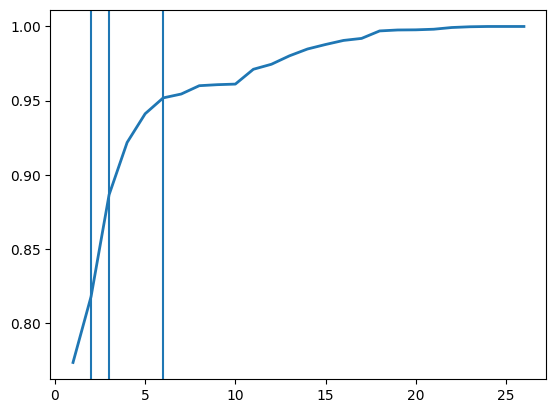

In [9]:
plt.figure()
plt.plot(
    np.arange(1, pca.n_components_ + 1), 1-pca.explained_variance_ratio_, linewidth=2
)
plt.axvline(2)
plt.axvline(3)
plt.axvline(6)

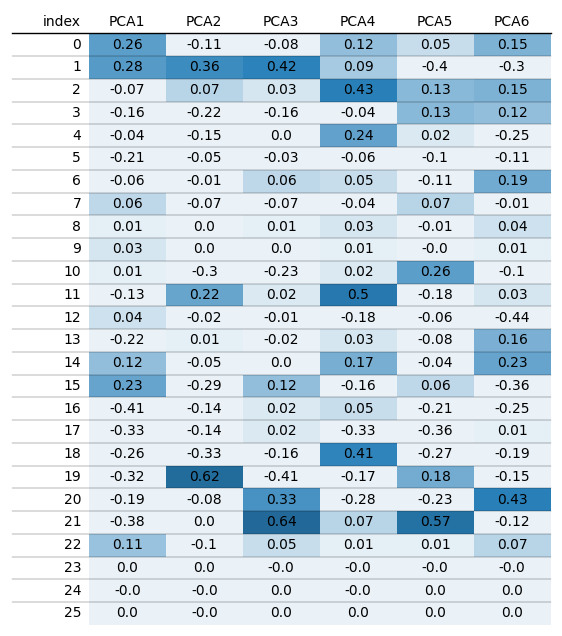

In [10]:
componets_pca = pd.DataFrame(pca.components_[:, 0:6].round(2), columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'], index=pca_data.columns)
pca_col = list(componets_pca.columns)
# pca_col.insert(0, 'Variable')
fig, ax = plt.subplots(figsize=(7, 8))

custom_colors = [
    '#eaf2f8',
    '#7fb3d5',
    '#5499c7',
    '#2980b9',
    '#2471a3',
    '#1f618d',
    '#1a5276',
    '#154360' 
]

# Create a ListedColormap
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", custom_colors)

col_def = (
    [
        ColumnDefinition(
            name=col,
            cmap=custom_cmap,
            textprops={"ha": "center"}
        )
        for col in pca_col
    ]
)

table_comp_pca = Table(componets_pca, column_definitions=col_def)

plt.show()

For the first component the biggest influence have Sleep Duration, Age, and Manager. For the second component the most important is Scientist, Accountant and again Sleep Duration. What is more Sleep Duration is also relevant for the third component, next to variables Teacher and Software Engineer.

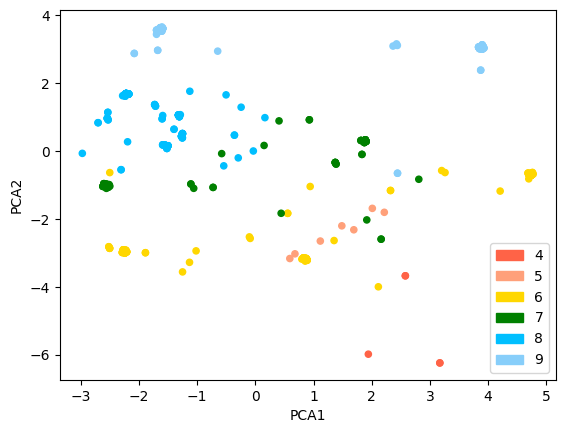

In [11]:
d = {
    'Quality of Sleep': data_with_dummies['Quality of Sleep'].astype("category"),
    'PCA1': output_pca[:, 0], 
    'PCA2': output_pca[:, 1],
    'PCA3': output_pca[:, 2]
}
pca_with_quality_of_sleep = pd.DataFrame(data=d)
colors = {4: 'tomato', 5: 'lightsalmon', 6: 'gold', 7: 'green', 8: 'deepskyblue', 9: 'lightskyblue'}
color_list = [colors[group] for group in pca_with_quality_of_sleep['Quality of Sleep']]

ax = pca_with_quality_of_sleep.plot.scatter('PCA1', 'PCA2', c=color_list)

legend_handles = [
    mpatches.Patch(color=colors[4], label='4'),
    mpatches.Patch(color=colors[5], label='5'),
    mpatches.Patch(color=colors[6], label='6'),
    mpatches.Patch(color=colors[7], label='7'),
    mpatches.Patch(color=colors[8], label='8'),
    mpatches.Patch(color=colors[9], label='9'),

]
ax.legend(handles=legend_handles,
          loc='lower right')


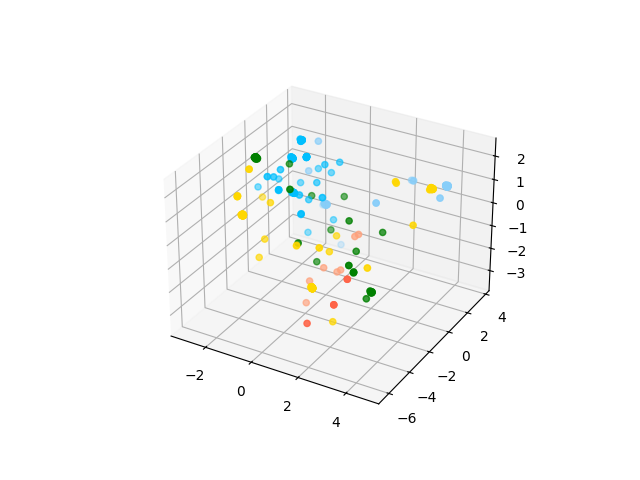

In [12]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(
    pca_with_quality_of_sleep['PCA1'], 
    pca_with_quality_of_sleep['PCA2'], 
    pca_with_quality_of_sleep['PCA3'], 
    c=color_list)
plt.show()


# Multiple Linear Regression

In order to begin, I will employ a fundamental statistical technique, namely linear regression. A comparison will be made between the results obtained for models created using the complete data set and those derived from the principal component analysis (PCA) data set.

## Model using PCA features

In [13]:
pd.DataFrame(output_pca).describe().round(2)

0       1       2       3       4       5       6       7       8   \
count  374.00  374.00  374.00  374.00  374.00  374.00  374.00  374.00  374.00   
mean    -0.00    0.00    0.00    0.00    0.00    0.00    0.00   -0.00    0.00   
std      2.43    2.18    1.72    1.43    1.24    1.12    1.09    1.02    1.01   
min     -2.97   -6.24   -3.49   -2.40   -7.63   -2.15   -1.62   -6.48   -5.88   
25%     -2.18   -1.06   -1.70   -1.31   -0.73   -0.50   -0.55   -0.36   -0.16   
50%     -1.27    0.16    0.14   -0.27    0.13   -0.16   -0.33    0.00   -0.03   
75%      1.87    1.63    1.60    1.16    1.01    0.59    1.08    0.31    0.05   
max      4.77    3.66    2.33    4.07    2.07    2.59    5.61    7.30    8.11   

           9   ...      16      17      18      19      20      21      22  \
count  374.00  ...  374.00  374.00  374.00  374.00  374.00  374.00  374.00   
mean     0.00  ...   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00    0.00   
std      1.01  ...    0.46    0.28    0.25    0.24    0.22    0.13    0.07   
min     -3.88  ...   -2.11   -0.73   -1.29   -1.07   -1.20   -0.63   -0.35   
25%     -0.08  ...   -0.26   -0.15   -0.10   -0.09   -0.05   -0.04   -0.02   
50%      0.05  ...   -0.03    0.04    0.02    0.01    0.01    0.00   -0.00   
75%      0.11  ...    0.21    0.09    0.13    0.11    0.05    0.04    0.02   
max     16.89  ...    1.55    1.48    1.14    0.69    0.84    0.57    0.42   

          23     24     25  
count  374.0  374.0  374.0  
mean    -0.0   -0.0    0.0  
std      0.0    0.0    0.0  
min     -0.0   -0.0   -0.0  
25%     -0.0   -0.0   -0.0  
50%      0.0   -0.0   -0.0  
75%      0.0    0.0    0.0  
max      0.0    0.0    0.0  

[8 rows x 26 columns]

Because components have similar values I will not standaradize it.

In [14]:
X_pca = pd.DataFrame(output_pca[:, 0:5], columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])
y_pca = list(data['Quality of Sleep'])

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3, stratify=y_pca, random_state=42)
terms_pca = X_pca.columns
X_train_lin_reg_pca = MS(terms_pca).fit_transform(X_train_pca)
model_pca = sm.OLS(y_train_pca, X_train_lin_reg_pca)
results_pca = model_pca.fit()
summarize(results_pca)

coef  std err        t  P>|t|
intercept  7.3263    0.021  350.925  0.000
PCA1      -0.0948    0.009  -10.934  0.000
PCA2       0.5001    0.010   52.522  0.000
PCA3       0.0385    0.012    3.091  0.002
PCA4      -0.1831    0.014  -12.665  0.000
PCA5       0.0117    0.017    0.675  0.500

Last component is not relevant therefore I remove it from dataset. Belove there is final model.

In [37]:
X_pca = pd.DataFrame(output_pca[:, 0:4], columns=['PCA1', 'PCA2', 'PCA3', 'PCA4'])
y_pca = list(data['Quality of Sleep'])

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3, stratify=y_pca, random_state=42)
terms_pca = X_pca.columns
X_train_pca = MS(terms_pca).fit_transform(X_train_pca)
X_test_pca = MS(terms_pca).fit_transform(X_test_pca)
model_pca = sm.OLS(y_train_pca, X_train_lin_reg_pca)
results_pca = model_pca.fit()
summarize(results_pca)

coef  std err        t  P>|t|
intercept  7.3262    0.021  351.304  0.000
PCA1      -0.0947    0.009  -10.945  0.000
PCA2       0.5001    0.010   52.577  0.000
PCA3       0.0385    0.012    3.097  0.002
PCA4      -0.1828    0.014  -12.664  0.000

## Model base on dataset variables

In [16]:
X = data[['Age', 'Sleep Duration', 'Heart Rate', 'Daily Steps', 'Diastolic']]
y = data['Quality of Sleep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [17]:
terms = ['Age', 'Sleep Duration', 'Heart Rate', 'Daily Steps', 'Diastolic']
X_train_lin_reg = MS(terms).fit_transform(X_train)
model = sm.OLS(y_train, X_train_lin_reg)
results = model.fit()
summarize(results)

coef   std err       t  P>|t|
intercept       5.382100  0.800000   6.725  0.000
Age             0.033700  0.005000   6.872  0.000
Sleep Duration  0.969100  0.045000  21.760  0.000
Heart Rate     -0.071800  0.009000  -8.415  0.000
Daily Steps     0.000026  0.000018   1.442  0.151
Diastolic      -0.018100  0.007000  -2.627  0.009

The coefficient of the Daily Steps variable is 0.000026, therefore, this variable will be removed from the model.

In [18]:
terms2 = ['Age', 'Sleep Duration', 'Heart Rate', 'Diastolic']
X_train_lin_reg2 = MS(terms2).fit_transform(X_train)
model = sm.OLS(y_train, X_train_lin_reg2)
results = model.fit()
summarize(results)

coef  std err       t  P>|t|
intercept       5.5227    0.796   6.938  0.000
Age             0.0325    0.005   6.713  0.000
Sleep Duration  0.9706    0.045  21.754  0.000
Heart Rate     -0.0742    0.008  -8.823  0.000
Diastolic      -0.0153    0.007  -2.313  0.022

The model above could be considered a final model, however, this would only be the case if categorical variables were to be ignored. Otherwise, the search for the most appropriate set of features for multinomial regression will continue.

In [19]:
all_data = list(data.columns.drop(['Quality of Sleep', 'Blood Pressure', 'Occupation']))
data[['Gender', 'BMI Category', 'Sleep Disorder']] = data[['Gender', 'BMI Category', 'Sleep Disorder']].astype("category")

# Second data split - with also categorical features
X_train_all, X_test_all, y_train, y_test = train_test_split(data[all_data], y, test_size=0.3, stratify=y, random_state=42)

# Model with all data 
X_train_all = MS(all_data).fit_transform(X_train_all)
X_test_all =  MS(all_data).fit_transform(X_test_all)
model_all = sm.OLS(y_train, X_train_all)
results_all = model_all.fit()
summarize(results_all)
#results_all.ssr
    

coef   std err       t  P>|t|
intercept                    8.773800  1.146000   7.658  0.000
Gender[Male]                 0.389900  0.070000   5.560  0.000
Age                          0.059200  0.006000   9.789  0.000
Sleep Duration               0.083800  0.065000   1.287  0.199
Physical Activity Level      0.002100  0.002000   0.929  0.354
Stress Level                -0.442000  0.036000 -12.192  0.000
BMI Category[Obese]         -0.451800  0.208000  -2.171  0.031
BMI Category[Overweight]    -0.632800  0.101000  -6.239  0.000
Heart Rate                  -0.008800  0.013000  -0.686  0.493
Daily Steps                  0.000025  0.000032   0.774  0.440
Sleep Disorder[None]         0.246800  0.067000   3.660  0.000
Sleep Disorder[Sleep Apnea]  0.290400  0.080000   3.630  0.000
Systolic                    -0.039000  0.021000  -1.891  0.060
Diastolic                    0.035800  0.028000   1.303  0.194

A number of variables have a p-value greater than 0.05, indicating that they are not statistically significant. However, in some cases, this may be due to a high correlation between variables. This phenomenon can be observed in the data set with respect to the relationship daily steps with physical activity level, sleep duration and stress level with heart rate and systolic with diastolic. Therefore I add 3 variable: Daily Steps:Physical Activity Level, Stress Level:Sleep Duration, Heart Rate:Sleep Duration, Heart Rate:Stress Level, Diastolic:Systolic.

In [20]:
columns_and_relationships = list(X_train_all.columns)
columns_and_relationships.remove('intercept')
columns_and_relationships = columns_and_relationships + [('Stress Level', 'Sleep Duration'), ('Heart Rate', 'Sleep Duration'),
                                                        ('Heart Rate', 'Stress Level'), ('Daily Steps', 'Physical Activity Level'),
                                                        ('Diastolic', 'Systolic')]

In [21]:
X_train_with_interaction = MS(columns_and_relationships).fit_transform(X_train_all)
model_all = sm.OLS(y_train, X_train_with_interaction)
results_all = model_all.fit()
summarize(results_all)

coef    std err      t  P>|t|
intercept                            7.261200  12.364000  0.587  0.558
Gender[Male]                        -0.204300   0.087000 -2.357  0.019
Age                                  0.016600   0.007000  2.282  0.023
Sleep Duration                       1.936500   1.082000  1.790  0.075
Physical Activity Level              0.054800   0.010000  5.652  0.000
Stress Level                         1.996700   0.515000  3.879  0.000
BMI Category[Obese]                 -0.658900   0.197000 -3.339  0.001
BMI Category[Overweight]            -0.338000   0.096000 -3.522  0.001
Heart Rate                           0.180200   0.151000  1.192  0.234
Daily Steps                          0.000500   0.000075  6.718  0.000
Sleep Disorder[None]                 0.177800   0.058000  3.088  0.002
Sleep Disorder[Sleep Apnea]          0.049000   0.080000  0.615  0.539
Systolic                            -0.057700   0.053000 -1.083  0.280
Diastolic                           -0.493400   0.102000 -4.857  0.000
Stress Level:Sleep Duration         -0.100800   0.029000 -3.478  0.001
Heart Rate:Sleep Duration           -0.013300   0.017000 -0.793  0.429
Heart Rate:Stress Level             -0.022000   0.008000 -2.780  0.006
Daily Steps:Physical Activity Level -0.000007   0.000001 -6.013  0.000
Diastolic:Systolic                   0.002400   0.001000  3.577  0.000

Heart Rate:Sleep Duration has high p-value, thus resulting in its removal from the dataset. A similar decision was made with respect to the variable 'Sleep Disorder [Sleep Apnea]', as it demonstrated a high degree of correlation with the 'Sleep Disorder [None]' variable. This observation led to the conclusion that the variable 'Sleep Disorder [Sleep Apnea]' did not contribute significantly to the dataset. 

In [22]:
columns_and_relationships.remove(('Heart Rate', 'Sleep Duration'))
columns_and_relationships.remove('Sleep Disorder[Sleep Apnea]')

### Model 1 - with relationships

In [23]:
X_train_with_interaction = MS(columns_and_relationships).fit_transform(X_train_all)
X_test_with_interaction = MS(columns_and_relationships).fit_transform(X_test_all)
model_all = sm.OLS(y_train, X_train_with_interaction)
results_all = model_all.fit()
summarize(results_all)

coef   std err      t  P>|t|
intercept                            15.826500  7.020000  2.255  0.025
Gender[Male]                         -0.207500  0.084000 -2.471  0.014
Age                                   0.014400  0.007000  2.113  0.036
Sleep Duration                        1.127000  0.145000  7.790  0.000
Physical Activity Level               0.055300  0.009000  5.903  0.000
Stress Level                          1.735700  0.358000  4.850  0.000
BMI Category[Obese]                  -0.717500  0.186000 -3.864  0.000
BMI Category[Overweight]             -0.317200  0.092000 -3.436  0.001
Heart Rate                            0.062600  0.027000  2.302  0.022
Daily Steps                           0.000500  0.000071  7.288  0.000
Sleep Disorder[None]                  0.170800  0.052000  3.276  0.001
Systolic                             -0.062800  0.052000 -1.207  0.229
Diastolic                            -0.516800  0.097000 -5.325  0.000
Stress Level:Sleep Duration          -0.117200  0.023000 -5.055  0.000
Heart Rate:Stress Level              -0.016600  0.004000 -3.788  0.000
Daily Steps:Physical Activity Level  -0.000007  0.000001 -6.329  0.000
Diastolic:Systolic                    0.002600  0.001000  3.927  0.000

The model presented above is the definitive model. All characteristics have a p-value below 0.05 except Systolic. It is highly correlated with Diastolic, so a new variable has been added: Diastolic*Systolic, which is statistically significant so I can leave both variables in the model.

I would like to see how look correlation between every variables and Quality of Sleep. Plots are printed below. 

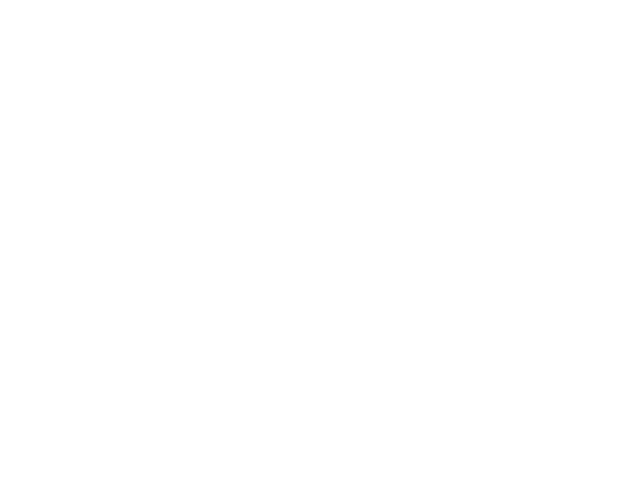

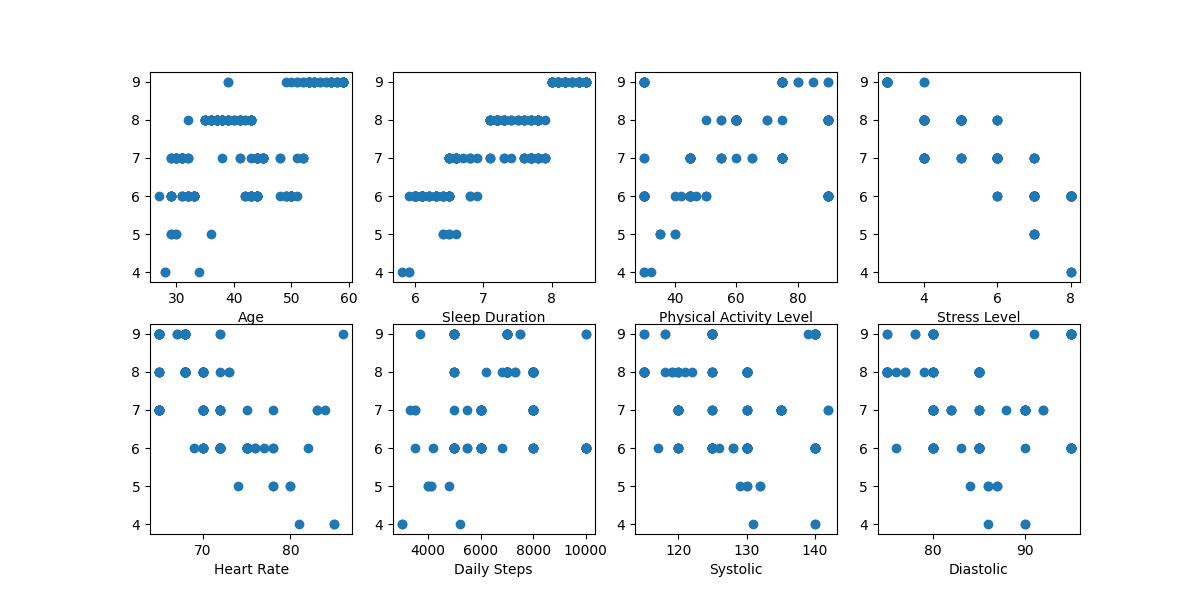

In [24]:
fig = plt.figure()
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize=(12, 6))
variables = ['Age', 'Sleep Duration', 'Physical Activity Level','Stress Level', 'Heart Rate', 'Daily Steps',
       'Systolic', 'Diastolic']

for (i, var), ax in zip(enumerate(variables), axes.ravel()):
    ax.scatter(X_train_with_interaction[var], y_train)
    ax.set_xlabel(var)

# plt.show()

Looking at the plots above it is not that between all variables have linear correlation with quality of sleep. Therefore I look also at the model with squared variables.

In [25]:
X_train_all['Age_2'] = pow(X_train_all['Age'], 2)
X_train_all['Sleep Duration_2'] = pow(X_train_all['Sleep Duration'], 2)
X_train_all['Physical Activity Level_2'] = pow(X_train_all['Physical Activity Level'], 2)
X_train_all['Heart Rate_2'] = pow(X_train_all['Heart Rate'], 2)
X_train_all['Daily Steps_2'] = pow(X_train_all['Daily Steps'], 2)
X_train_all['Systolic_2'] = pow(X_train_all['Systolic'], 2)
X_train_all['Diastolic_2'] = pow(X_train_all['Diastolic'], 2)

In [26]:
X_test_all['Age_2'] = pow(X_test_all['Age'], 2)
X_test_all['Sleep Duration_2'] = pow(X_test_all['Sleep Duration'], 2)
X_test_all['Physical Activity Level_2'] = pow(X_test_all['Physical Activity Level'], 2)
X_test_all['Heart Rate_2'] = pow(X_test_all['Heart Rate'], 2)
X_test_all['Daily Steps_2'] = pow(X_test_all['Daily Steps'], 2)
X_test_all['Systolic_2'] = pow(X_test_all['Systolic'], 2)
X_test_all['Diastolic_2'] = pow(X_test_all['Diastolic'], 2)

In [27]:
columns_and_relationships_2 = list()
columns_and_relationships_2 = list(columns_and_relationships)
columns_and_relationships_2 = columns_and_relationships_2 + ['Age_2', 'Sleep Duration_2', 'Physical Activity Level_2', 'Heart Rate_2', 'Systolic_2', 'Diastolic_2']

In [28]:
X_train_2 = MS(columns_and_relationships_2).fit_transform(X_train_all)
model_2 = sm.OLS(y_train, X_train_2)
results_2 = model_2.fit()
summarize(results_2)

coef    std err      t  P>|t|
intercept                           -63.305000  15.857000 -3.992  0.000
Gender[Male]                         -0.272000   0.078000 -3.508  0.001
Age                                   0.069000   0.026000  2.658  0.008
Sleep Duration                        4.389500   1.324000  3.315  0.001
Physical Activity Level               0.020800   0.012000  1.688  0.093
Stress Level                          0.741200   0.519000  1.427  0.155
BMI Category[Obese]                  -0.038500   0.355000 -0.108  0.914
BMI Category[Overweight]             -0.189200   0.084000 -2.245  0.026
Heart Rate                            1.095800   0.179000  6.109  0.000
Daily Steps                           0.000700   0.000087  8.413  0.000
Sleep Disorder[None]                  0.072500   0.046000  1.572  0.117
Systolic                             -0.238200   0.405000 -0.588  0.557
Diastolic                             0.501200   0.414000  1.212  0.227
Stress Level:Sleep Duration          -0.031000   0.046000 -0.672  0.502
Heart Rate:Stress Level              -0.013700   0.005000 -2.893  0.004
Daily Steps:Physical Activity Level  -0.000009   0.000001 -6.904  0.000
Diastolic:Systolic                   -0.179700   0.025000 -7.259  0.000
Age_2                                -0.000700   0.000000 -2.365  0.019
Sleep Duration_2                     -0.262000   0.082000 -3.202  0.002
Physical Activity Level_2             0.000300   0.000097  2.745  0.007
Heart Rate_2                         -0.006900   0.001000 -5.352  0.000
Systolic_2                            0.060700   0.009000  6.819  0.000
Diastolic_2                           0.132400   0.018000  7.505  0.000

All squared variables are significant at level of 0.05, but some of the latest variables (BMI Category[Obese], Sleep Disorder[None], Stress Level:Sleep Duration) seem to be unimportant and as a result they will be removed.

In [29]:
columns_and_relationships_2_1 = list(columns_and_relationships_2)
columns_and_relationships_2_1.remove('BMI Category[Obese]')
columns_and_relationships_2_1.remove('Sleep Disorder[None]')
columns_and_relationships_2_1.remove(('Stress Level', 'Sleep Duration'))

### Model 2 - with squared variables

In [30]:
X_train_2_1 = MS(columns_and_relationships_2_1).fit_transform(X_train_all)
X_test_2_1 = MS(columns_and_relationships_2_1).fit_transform(X_test_all)
model_2_1 = sm.OLS(y_train, X_train_2_1)
results_2_1 = model_2_1.fit()
summarize(results_2_1)

coef   std err       t  P>|t|
intercept                           -66.555300  8.564000  -7.772  0.000
Gender[Male]                         -0.253200  0.073000  -3.486  0.001
Age                                   0.073000  0.025000   2.897  0.004
Sleep Duration                        3.753700  0.997000   3.765  0.000
Physical Activity Level               0.018400  0.012000   1.552  0.122
Stress Level                          0.445000  0.281000   1.582  0.115
BMI Category[Overweight]             -0.216800  0.082000  -2.636  0.009
Heart Rate                            1.165800  0.138000   8.434  0.000
Daily Steps                           0.000800  0.000075  10.174  0.000
Systolic                             -0.145900  0.244000  -0.597  0.551
Diastolic                             0.450300  0.307000   1.465  0.144
Heart Rate:Stress Level              -0.012900  0.004000  -3.204  0.002
Daily Steps:Physical Activity Level  -0.000009  0.000001  -7.814  0.000
Diastolic:Systolic                   -0.193500  0.019000 -10.398  0.000
Age_2                                -0.000800  0.000000  -2.574  0.011
Sleep Duration_2                     -0.230100  0.070000  -3.297  0.001
Physical Activity Level_2             0.000300  0.000085   3.457  0.001
Heart Rate_2                         -0.007400  0.001000  -7.929  0.000
Systolic_2                            0.064800  0.007000   9.954  0.000
Diastolic_2                           0.143200  0.013000  10.856  0.000

The model above represents the second model, which, in contrast to the first, takes into account the non-linear correlation between variables. \
In the third and final model, the VIF (variance inflation factor) is also examined. This factor is used to identify the correlation between two, three, or more variables that is not apparent in the correlation matrix. This issue is named multicollinearity. The minimum value of vif is 1 and that's mean there is no collinearity. Acceptable value is less than 5-10.

In [31]:
# X_train_2s = pd.DataFrame(StandardScaler().fit_transform(X_train_2_1), columns=X_train_2.columns)
col = list(X_train_all.columns)
idx_col = [1, 4, 5, 6, 7, 10, 11, 14]
col = [col[i] for i in idx_col]
X_vif = pd.DataFrame(X_train_all.iloc[:, idx_col], columns=col)
vals = [VIF(X_vif, i) for i in range(0, X_vif.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=X_vif.columns[0:])
vif.round()

vif
Gender[Male]                  4.0
Physical Activity Level      10.0
Stress Level                 10.0
BMI Category[Obese]           1.0
BMI Category[Overweight]      5.0
Sleep Disorder[None]          7.0
Sleep Disorder[Sleep Apnea]   3.0
Age_2                         9.0

Recorded best data sets (vif equal to or less than 10):\

    vif
Gender[Male]	2.0
BMI Category[Obese]	1.0
BMI Category[Overweight]	2.0
Sleep Disorder[None]	2.0
Sleep Disorder[Sleep Apnea]	2.0

	vif
Gender[Male]	2.0
Physical Activity Level	9.0
BMI Category[Obese]	1.0
BMI Category[Overweight]	3.0
Sleep Disorder[None]	5.0
Sleep Disorder[Sleep Apnea]	3.0

    vif
Gender[Male]	4.0
Physical Activity Level	9.0
Stress Level	10.0
BMI Category[Obese]	1.0
BMI Category[Overweight]	4.0
Sleep Disorder[None]	6.0
Sleep Disorder[Sleep Apnea]	3.0

    vif
Gender[Male]	3.0
Physical Activity Level	10.0
BMI Category[Obese]	1.0
BMI Category[Overweight]	4.0
Sleep Disorder[None]	6.0
Sleep Disorder[Sleep Apnea]	3.0
Age_2	9.0

    vif
Physical Activity Level	10.0
Stress Level	7.0
BMI Category[Obese]	1.0
BMI Category[Overweight]	5.0
Sleep Disorder[None]	7.0
Sleep Disorder[Sleep Apnea]	3.0
Age_2	8.0

    vif
Gender[Male]	4.0
Physical Activity Level	10.0
Stress Level	10.0
BMI Category[Obese]	1.0
BMI Category[Overweight]	5.0
Sleep Disorder[None]	7.0
Sleep Disorder[Sleep Apnea]	3.0
Age_2	9.0

    vif
Physical Activity Level	9.0
Stress Level	7.0
BMI Category[Obese]	1.0
BMI Category[Overweight]	3.0
Sleep Disorder[None]	5.0
Sleep Disorder[Sleep Apnea]	2.0

    vif
Stress Level	6.0
BMI Category[Obese]	1.0
BMI Category[Overweight]	5.0
Sleep Disorder[None]	7.0
Sleep Disorder[Sleep Apnea]	2.0


### Model 3 - after vif

In [32]:
X_train_s = MS(col).fit_transform(X_train_all)
X_test_s = MS(col).fit_transform(X_test_all)
model_s = sm.OLS(y_train, X_train_s)
results_s = model_s.fit()
summarize(results_s)

coef   std err       t  P>|t|
intercept                    8.3786  0.152000  55.221   0.00
Gender[Male]                 0.3337  0.052000   6.437   0.00
Physical Activity Level      0.0056  0.001000   5.351   0.00
Stress Level                -0.4823  0.015000 -31.613   0.00
BMI Category[Obese]         -0.9019  0.131000  -6.910   0.00
BMI Category[Overweight]    -0.7014  0.069000 -10.237   0.00
Sleep Disorder[None]         0.2646  0.068000   3.874   0.00
Sleep Disorder[Sleep Apnea]  0.1891  0.072000   2.613   0.01
Age_2                        0.0006  0.000041  15.387   0.00

### Model comparison

In [33]:
test_n = len(y_test)

In [38]:
predictions_1 = results_all.get_prediction(X_test_with_interaction)
predictions_2 = results_2_1.get_prediction(X_test_2_1)
predictions_3 = results_s.get_prediction(X_test_s)
prediction_pca = results_pca.get_prediction(X_test_pca)

test_sse1 = pow(y_test - predictions_1.predicted, 2).sum()
test_sse2 = pow(y_test - predictions_2.predicted, 2).sum()
test_sse3 = pow(y_test - predictions_3.predicted, 2).sum()
test_sse_pca = pow(y_test - prediction_pca.predicted, 2).sum()

y_test_mean = sum(y_test)/test_n

test_ss_total = pow(y_test - y_test_mean, 2).sum()

test_r2_1 = 1-(test_sse1/test_ss_total)
test_r2_2 = 1-(test_sse2/test_ss_total)
test_r2_3 = 1-(test_sse3/test_ss_total)
test_r2_pca = 1-(test_sse_pca/test_ss_total)

model_comparison = pd.DataFrame({
    'train_adjusted_r2': [results_all.rsquared_adj, results_2_1.rsquared_adj, results_s.rsquared_adj, results_pca.rsquared_adj],
    'test_adjusted_r2': [test_r2_1, test_r2_2, test_r2_3, test_r2_pca],
    # 'train_rss': [results_all.ssr, results_2_1.ssr, results_s.ssr],
    'train_mse' : [results_all.mse_resid, results_2_1.mse_resid, results_s.mse_resid, results_pca.mse_resid],
    # 'test_rss': [test_sse1, test_sse2, test_sse3],
    'test_mse': [test_sse1/test_n, test_sse2/test_n, test_sse3/test_n, test_sse_pca/test_n]
})

model_comparison.index = ['model 1', 'model 2', 'model 3', 'model PCA']
model_comparison

train_adjusted_r2  test_adjusted_r2  train_mse  test_mse
model 1             0.961385          0.971987   0.054798  0.040994
model 2             0.972790          0.958082   0.038613  0.061342
model 3             0.936101          0.960165   0.090679  0.058295
model PCA           0.920468          0.924121   0.112864  0.111040

All models achieved good results, but model 1 outperformed the other models, with superior results on both the training and test sets in comparison to model 3. Model 2 achieved better results on the training set, but worse results on the test set, indicating that model 1 performs better in predicting unseen values. This superior performance of model 1 in predicting unseen values justifies its selection as the optimal model.
When comparing a model built on the principal components with models built on initial variables, better results, on both the training and test sets, are achieved by the latter.

# Machine Learning methods

Beside multinomial regression I would like to test different methods to find the best model for classification in this case.